Il nuovo metodo si basa su una semplificazione di quello precedente;
L'intuizione è che si può ottenere la distanza lungo x e lungo y tramite un vettore, invece che una matrice, a patto che lo sguardo del robot sia centrato lungo la dimensione width dell'immagine sulla palla(quindi il robot veda la palla esattamente al centro dell'asse x)
Se questa condizione è soddisfatta, allora misurando le distanze viste dal robot in cm e convertendole in px è pssibile sapere quanto la palla è distante dal robot e di conseguenza calcolare la distanza da percorrere lungo x e lungo y anche se la palla non è direttamente nel campo visivo del robot, facendogli muovere la testa verso destra e sinistra(lungo la direzione di yaw quindi) per trovarla e poi utilizzando l'angolo di rotazione della testa per calcolare i valori che ci interessano

Nella cartella sono disponibili altri file che si sono resi necessari a scopo di debug; nello specifico, per provare il funzionamento del robot su video pre-registrati, ho creato uno script(320x320.py) che fa il resize del video in modo da riportarlo a una dimensione di 320x320px, in modo da mantenere le proporzioni dell'immagine coerenti con le misurazioni. Inoltre è dispionibile uno script(disegna_righe.py) che disegna delle linee ogni 10 cm sul video, per capire se l'altezza riconosciuta della palla è coerente con la sua posizione effettiva. Nello specifico, partendo dal file "video.avi" si ottinene "320x320.avi" e poi applicando "disegna_righe.avi" si ottiene "320x320with_lines.avi", che è il video utilizzato durante le prove.

Il codice da utilizzare per replicare le mie prove è all'interno di "vettore.py"
Il codice da eseguire se si ha a disposizione un robot è in "acquis.py" e "detect.py"

Per prima cosa abbiamo fissato l'altezza della testa del robot a 6.4 gradi lungo la direzione yaw, abbiamo posizionato a terra dei segnali ogni 10cm per capire a quanti pixel corrispondessero quelle distanze 

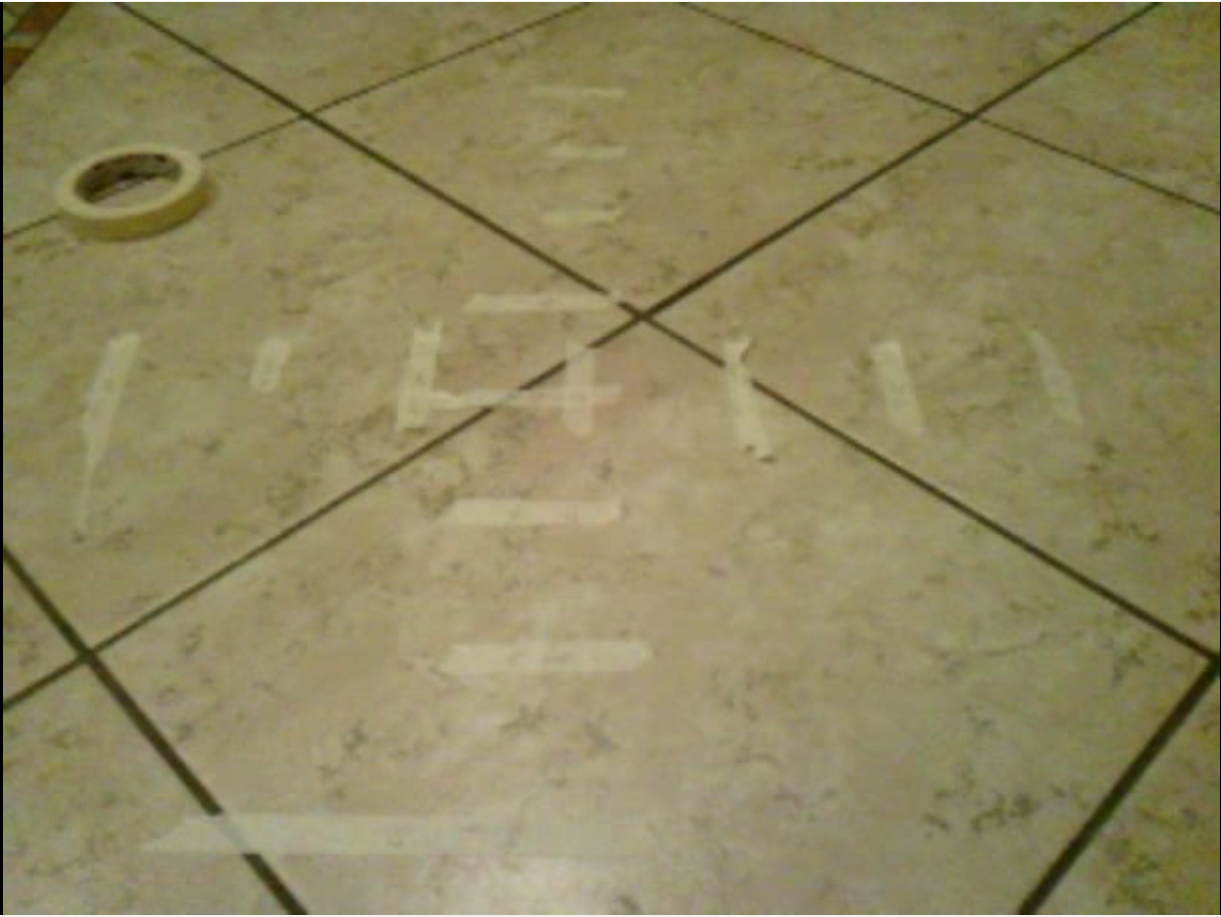

*il segno visibile più vicino si trova a una distanza di 20cm dal centro del robot

dopodiché per conoscere la posizione precisa al pixel, ho disegnato delle rette sull'immagine

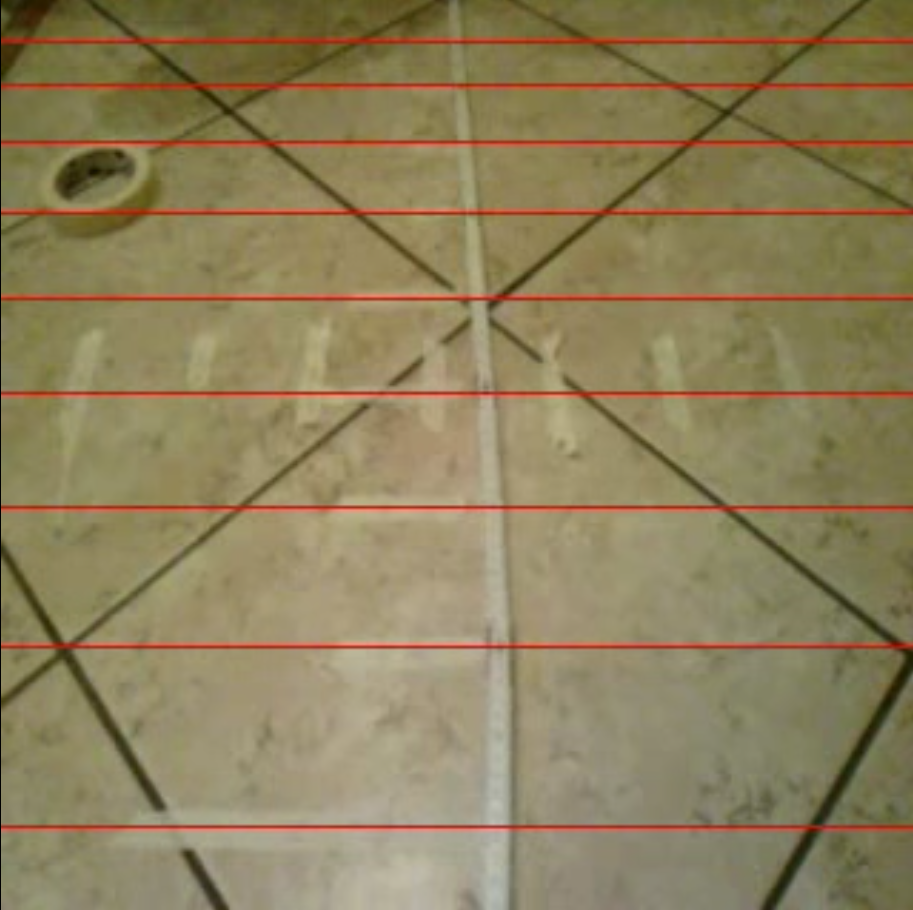

L'altezza delle linee espressa in pixel è stata salvata in un vettore 
[30,93,142,182,215,245,270,290,300]
Questo vuol dire che la prima liena si trova a 30px dal basso, la seconfa a 93px e così via.

Quindi a partire da un immagine 320px*320px siamo in grado di capire la distanza dalla palla, se questa è posta centralmente

Le linee quindi vengono disegnate solo all'inizio per calcolare il vettore, ma poi non sono più necessarie, se non a scopo di debug; in rari casi possono anche disturbare il riconoscimento della palla, quindi all'infuori dei test si consiglia di non disegnarle

A questo punto inizia la spiegazione del codice vero e proprio

Oltre al setup iniziale di detect.py, in cui avviene lo scambio di messaggi tra acquis.py e detect.py, vengono calcolati i valori del rettangolo che circonda la palla

In [ ]:
min_conf = 0.4
	if (scores[0] *100) > min_conf*100 :
        xmin = int(max(1,(boxes[0][1] * image_width)))
		xmax = int(min(image_width,(boxes[0][3] * image_width)))
		ymin = int(max(1,(boxes[0][0] * image_height)))
		ymax = int(min(image_height,(boxes[0][2] * image_height)))
		cv2.rectangle(im, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

Se la palla è già nella visuale del robot, alllora il robot utilizza la seguente porzione di codice per fare in modo di avere la palla in un intorno del centro della width dell'immagine, salvando l'angolo della rotazione della testa e calcolando la distanza grazie al vettore di partenza

In [ ]:
	x_center = xmax - (xmax-xmin)/2
		int i = 0;
		if (x_center >= width/2):
			while((x_center <= (width/2)-5) or (x_center >= (width/2)+5)):
				motion.setAngles(nomi_motori, 1, 0.5)
				i=i+1
			rotation = i
			distanza = ymax - (ymax-xmin)/2
		else:
			while((x_center <= (width/2)-5) or (x_center >= (width/2)+5)):
				motion.setAngles(nomi_motori, -1, 0.5)
				i=i+1
			rotation = -i
			distanza = ymax - (ymax-xmin)/2

Se il robot invece non trova la palla nella sua visuale, allora inizia a girare la testa, prima verso destra di 50° e poi verso sinistra, sempre di 50° 

Anche in questo caso il robot incrementa di un grado ogni volta l'angolo di rotazione orizzontale, finchè la palla non è posizionata circa al centro della width dell'immagine

In [ ]:
# Esegui la rotazione a destra
		for i in range(0, angolo_destra)
			motion.setAngles(nomi_motori, 1, 0.5)
			if (scores[0] *100) > min_conf*100
				xmin = int(max(1,(boxes[0][1] * imW)))
				xmax = int(min(imW,(boxes[0][3] * imW)))
				ymin = int(max(1,(boxes[0][0] * imH)))
				ymax = int(min(imH,(boxes[0][2] * imH)))
				ball_center = xmax - (xmax-xmin)/2
				if (ball_center >= (width/2)-5 and ball_center <= (width/2)+5)
					rotation = i
					distanza = ymax - (ymax-xmin)/2
					break

Il centro della palla viene calcolato partendo dalla posizione max_width e sottraendogli metà della larghezza del quadrato(stessa cosa per l'altezza)

In [ ]:
x_center = xmax - (xmax-xmin)/2

Se la palla si trova in un intorno del centro

In [ ]:
if (x_center >= (width/2)-5 and x_center <= (width/2)+5)

allora salviamo i dati relativi all'angolo e all'altezza della palla all'interno dell'immagine

Se a destra non viene trovato nulla, allora la testa si riposiziona al centro e ripete lo stesso movimento verso sinistra

Una volta ottenuti rotation e distanza si procede come segue:

In [ ]:
distanza_minima = 305 #valore grande arbitrario
        for i in range(len(vettore_distanze)):
            if(abs((distanza - vettore_distanze[i])) < distanza_minima):
                distanza_minima = distanza - vettore_distanze[i]
                posizione_vicina = i

viene effettuato un calcolo del minimo della differenza tra distanza e il vettore di partenza (in modo da trovare il valore più prossimo) e si salva la posizione corrispondente; si utilizza abs perchè noi siamo interessati alla più piccola distanza in valore assoluto e non ci interessano i valori negativi.

In [ ]:
#la distanza lungo y viene ottenuta moltiplicando 10 cm * la posizione del vettore il cui numero di pixel si avvicina di più al centro della palla * coseno dell'angolo di rotazione
distanza_y =(10 * (posizione_vicina+1)) * math.cos(rotation)
#la distanza lungo x sarà l'ipotenusa del rettangolo che si crea per il seno di rotation
distanza_x =(10 * (posizione_vicina+1)) * math.sin(rotation)

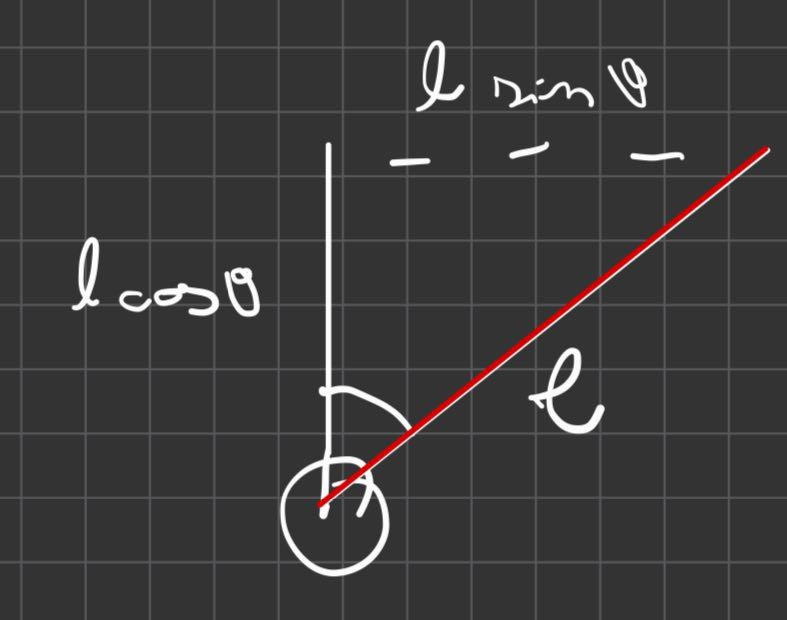

nel video utilizzato per le prove si può vedere che, la distanza calcolata lungo x e lungo y, se si fa ruotare la testa del robot di 45° verso sinistra(quindi -45 nelle coordinate del robot) le distanze misurate da percorrere sono di 
-59.56 lungo x e 36.77 lungo y quando la palla è vicina alla posizione 7 del video, con una distanza effettiva misurata a mano con un metro di -60cm lungo x e 40 cm lungo y

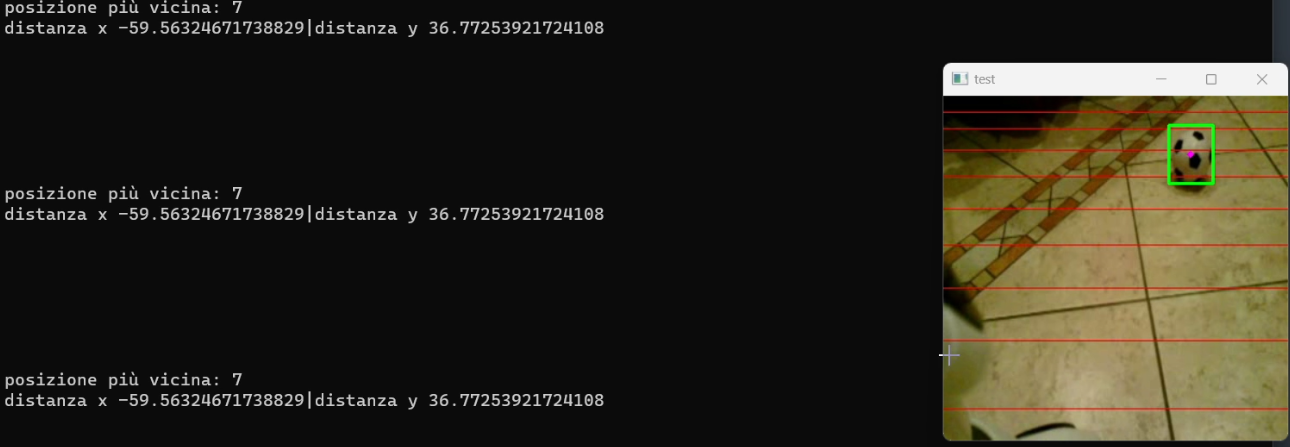

e una seconda misurazione, quando la palla si ferma vicino alla posizione 5 di -42.54 lungo x e 26.26 lungo y, con una distanza misurata a mano di -43 lungo x e 28 lungo y

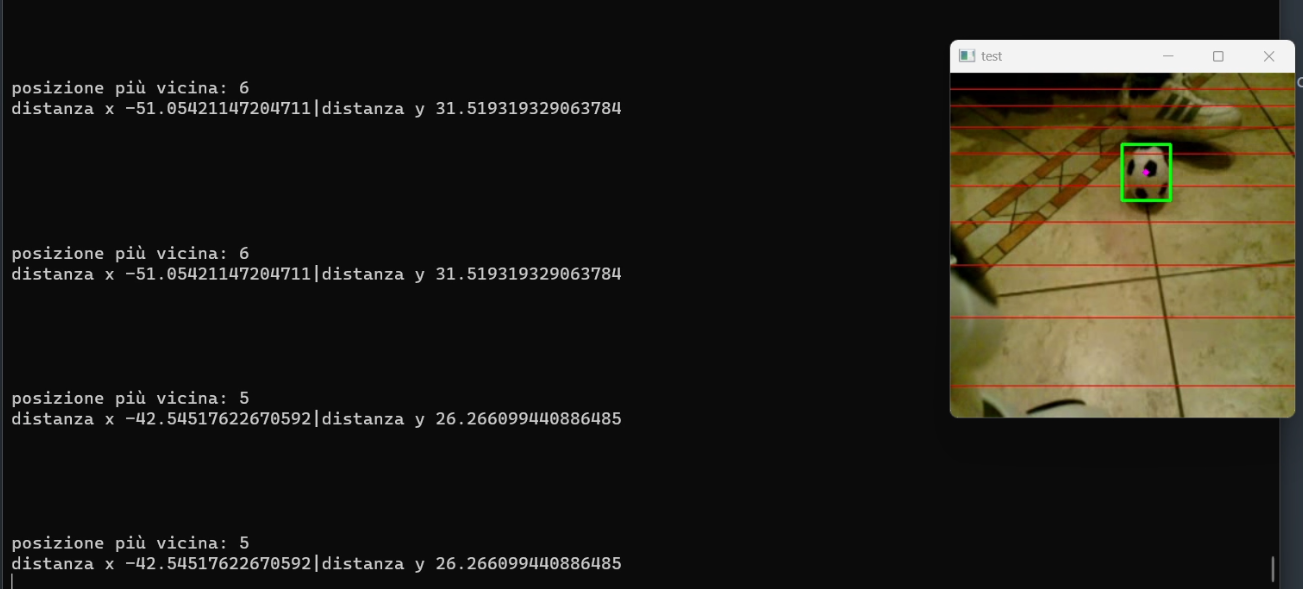